In [ ]:
import pandas as pd

In [ ]:
hyundai = pd.read_csv('/content/005380_hyundai.csv')
samsung = pd.read_csv('/content/005930_samsung.csv')
kepco = pd.read_csv('/content/015760_kepco.csv')

In [ ]:
samsung['date'] = samsung['date'].astype('str')
samsung['date'] = pd.to_datetime(samsung['date'])
samsung.index = samsung['date']
samsung.set_index('date', inplace=True)

In [ ]:
samsung_train_df = samsung[:971]
samsung_test_df = samsung[971:]

In [ ]:
samsung_test_df

,open,high,low,close,volume,per,pbr,roe,market_kospi_ma5_ratio,market_kospi_ma20_ratio,market_kospi_ma60_ratio,market_kospi_ma120_ratio,bond_k3y_ma5_ratio,bond_k3y_ma20_ratio,bond_k3y_ma60_ratio,bond_k3y_ma120_ratio
date,,,,,,,,,,,,,,,,
2019-12-23,56100.0,56400.0,55100.0,55500.0,9839252.0,9.04,1.15,13.42,0.997957,1.015010,1.002079,1.013144,1.000018,0.998755,0.997720,0.995154
2019-12-24,55600.0,55700.0,54800.0,55000.0,11868463.0,9.04,1.15,13.42,0.988089,1.002355,0.988296,1.000266,1.000299,0.999169,0.998123,0.995479
2019-12-26,54700.0,55400.0,54400.0,55400.0,9645034.0,9.04,1.15,13.42,1.007469,1.022626,1.007865,1.021415,1.000245,0.999267,0.998169,0.995454
2019-12-27,55700.0,56900.0,55500.0,56500.0,12313056.0,9.04,1.15,13.42,1.017427,1.035297,1.021272,1.036185,0.999973,0.999187,0.997981,0.995209
2019-12-30,56200.0,56600.0,55700.0,55800.0,8356767.0,9.04,1.15,13.42,1.024308,1.045730,1.033333,1.049980,1.000390,1.000034,0.998697,0.995862


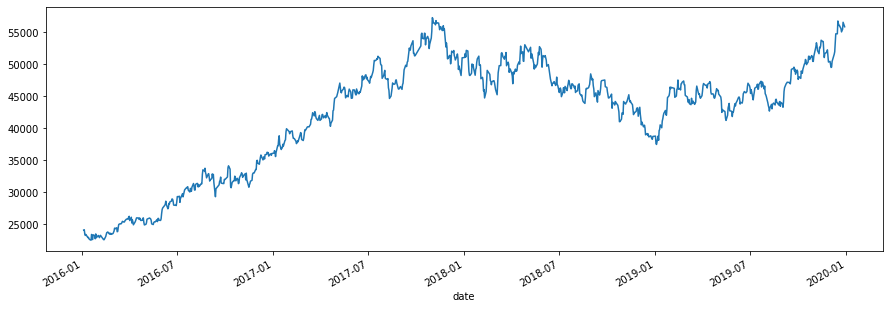

In [ ]:
samsung['close'].plot(figsize=(15,5))

### **ARIMA model**

ADF 검정으로 정상성 확인

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(samsung_train_df.close)
print(f'원 데이터 ADF Statistic: {result[0]:.3f}')
print(f'원 데이터 p-value: {result[1]:.3f}')

diff_1 = samsung_train_df.diff(periods=1).iloc[3]
result1 = adfuller(diff_1)
print(f'1차 차분 ADF Statistic: {result1[0]:.3f}')
print(f'1차 차분 p-value: {result1[1]:.3f}')


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



원 데이터 ADF Statistic: -1.544
원 데이터 p-value: 0.512
1차 차분 ADF Statistic: -188.231
1차 차분 p-value: 0.000


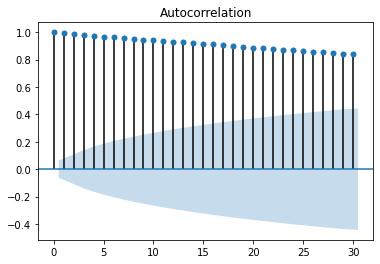

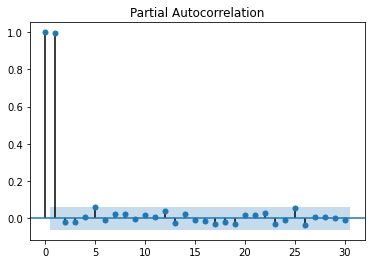

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(samsung_train_df.close)
plot_pacf(samsung_train_df.close)
plt.show()

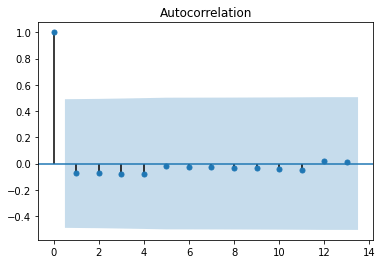

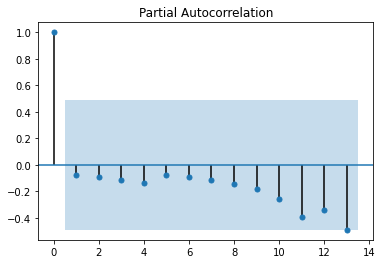

In [ ]:
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(samsung_train_df.close.values, order=(2,1,1))
model_fit = model.fit(trend='c',full_output=True, disp = True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  970
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -7699.972
Method:                       css-mle   S.D. of innovations            678.008
Date:                Tue, 26 Oct 2021   AIC                          15409.943
Time:                        06:03:29   BIC                          15434.330
Sample:                             1   HQIC                         15419.225
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         32.4289     16.386      1.979      0.048       0.314      64.544
ar.L1.D.y      0.9458      0.094     10.081      0.000       0.762       1.130
ar.L2.D.y     -0.0527      0.034     -1.556      0.1

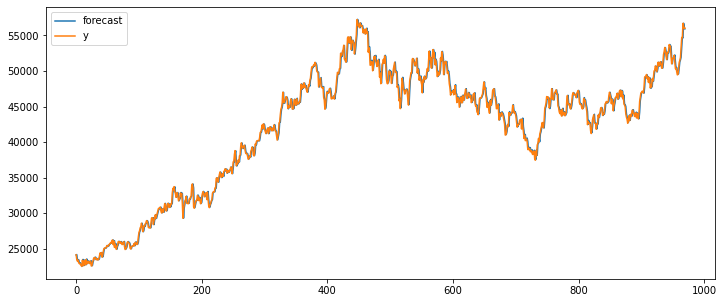

In [ ]:
# 학습한 ARIMA 모델에 학습 데이터를 넣어 예측한 결과
plt.rcParams["figure.figsize"] = (12,5)
fig = model_fit.plot_predict()

In [ ]:
forecast_data = model_fit.forecast(steps=5)
pred = forecast_data[0].tolist()
real = samsung_test_df.close.values

result_df = pd.DataFrame(pred, columns=['pred'])
result_df['real'] = real.reshape(-1)
result_df['diff'] = result_df['real'] - result_df['pred']
result_df

,pred,real,diff
0,55944.039782,55500.0,-444.039782
1,55894.582546,55000.0,-894.582546
2,55854.223187,55400.0,-454.223187
3,55822.125635,56500.0,677.874365
4,55797.362492,55800.0,2.637508


In [ ]:
pred_y_lower = []
pred_y_upper = []

for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

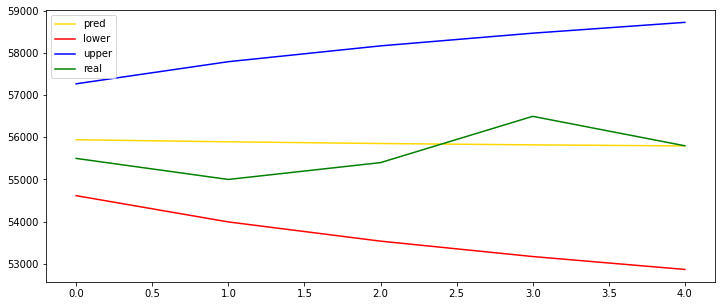

In [ ]:
plt.plot(pred, color = 'gold') #예측
plt.plot(pred_y_lower, color = 'red') #예측 하한가
plt.plot(pred_y_upper, color = 'blue') #예측 상한가
plt.plot(real, color = 'green') #실제
plt.legend(['pred', 'lower', 'upper', 'real'])

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

rmse = sqrt(mean_squared_error(pred, real))
print("ARIMA model RMSE: ", rmse)

ARIMA model RMSE:  576.764869635901


### **Facebook Prophet model (트렌드를 예측하는 것에 초점)**

선형회귀 분석의 단점을 극복하기 위한 Additive model

In [ ]:
from fbprophet import Prophet
samsung_df = pd.read_csv('/content/005930_samsung.csv')
samsung_df = samsung_df.loc[:, ['date', 'close']]
samsung_df['date'] = samsung_df['date'].astype('str')
samsung_df['date'] = pd.to_datetime(samsung_df['date'])
samsung_df.columns = ['ds', 'y']

,ds,y
0,2016-01-04,24100.0
1,2016-01-05,24160.0
2,2016-01-06,23500.0
3,2016-01-07,23260.0
4,2016-01-08,23420.0
...,...,...
971,2019-12-23,55500.0
972,2019-12-24,55000.0
973,2019-12-26,55400.0
974,2019-12-27,56500.0


In [ ]:
prophet_train = samsung_df[:971]

In [ ]:
prophet = Prophet(seasonality_mode = 'multiplicative', yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True, changepoint_prior_scale=0.5)
prophet.fit(prophet_train)

In [ ]:
future = prophet.make_future_dataframe(periods = 5)
forecast_data2 = prophet.predict(future)

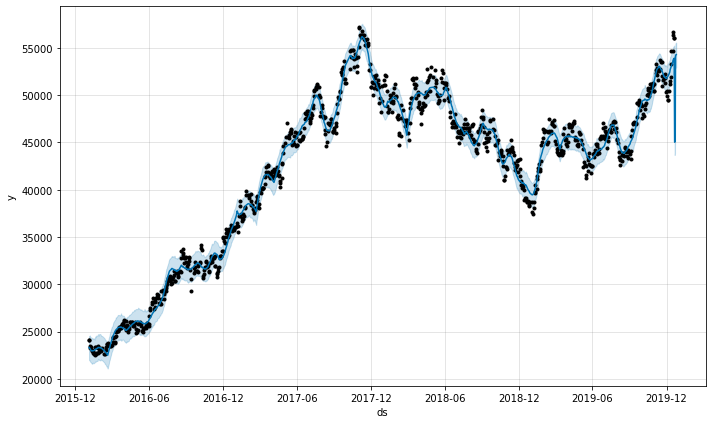

In [ ]:
fig1 = prophet.plot(forecast_data2)

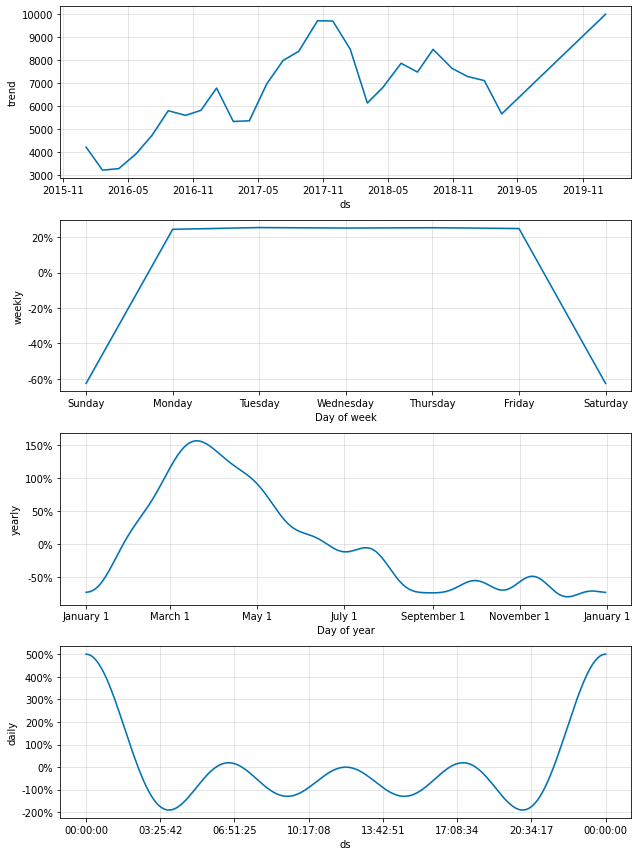

In [ ]:
#전체적인 트렌드와 weekly, yearly, daily
fig2 = prophet.plot_components(forecast_data2)

In [ ]:
forecast_data2.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
971,2019-12-21,9066.206167,43669.248247,46290.400678,9066.206167,9066.206167,5.653828,5.653828,5.653828,3.965684,3.965684,3.965684,-0.706729,-0.706729,-0.706729,-0.981416,-0.981416,-0.981416,0.0,0.0,0.0,45019.914447
972,2019-12-22,9080.677826,43816.390154,46473.289753,9080.677826,9080.677826,5.653828,5.653828,5.653828,3.964218,3.964218,3.964218,-0.706729,-0.706729,-0.706729,-0.982881,-0.982881,-0.982881,0.0,0.0,0.0,45078.465080
973,2019-12-23,9095.149484,52763.320522,55393.906336,9095.149484,9095.149484,5.653828,5.653828,5.653828,4.943120,4.943120,4.943120,0.274365,0.274365,0.274365,-0.985073,-0.985073,-0.985073,0.0,0.0,0.0,54053.568354
974,2019-12-24,9109.621143,52881.893684,55544.843517,9109.621143,9109.621143,5.653828,5.653828,5.653828,4.953530,4.953530,4.953530,0.287474,0.287474,0.287474,-0.987772,-0.987772,-0.987772,0.0,0.0,0.0,54234.402198
975,2019-12-25,9124.092801,52964.229226,55548.597407,9124.092801,9124.092801,5.653828,5.653828,5.653828,4.948640,4.948640,4.948640,0.285535,0.285535,0.285535,-0.990722,-0.990722,-0.990722,0.0,0.0,0.0,54275.947329


In [ ]:
pred2 = forecast_data2.yhat.values[-5:]
real2 = samsung_df.y.values[-5:]
pred_lower = forecast_data2.yhat_lower.values[-5:]
pred_upper = forecast_data2.yhat_upper.values[-5:]

result_df2 = pd.DataFrame(pred2, columns=['pred'])
result_df2['real'] = real2.reshape(-1)
result_df2['diff'] = result_df2['real'] - result_df2['pred']
result_df2

,pred,real,diff
0,45019.914447,55500.0,10480.085553
1,45078.465080,55000.0,9921.534920
2,54053.568354,55400.0,1346.431646
3,54234.402198,56500.0,2265.597802
4,54275.947329,55800.0,1524.052671


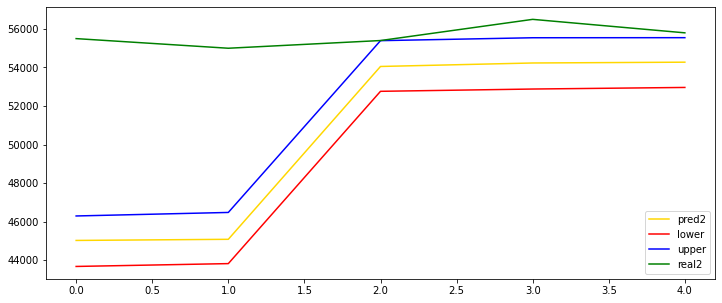

In [ ]:
plt.plot(pred2, color = 'gold') #예측
plt.plot(pred_lower, color = 'red') #예측 하한가
plt.plot(pred_upper, color = 'blue') #예측 상한가
plt.plot(real2, color = 'green') #실제
plt.legend(['pred2', 'lower', 'upper', 'real2'])

In [ ]:
rmse2 = sqrt(mean_squared_error(pred2, real2))
print("Facebook Prophet RMSE: ", rmse2)

Facebook Prophet RMSE:  6596.022991045459


### **주가 데이터 불러오기(LSTM)**

In [1]:
pip install finance-datareader

In [77]:
#우정바이오 215380 / 엑세스바이오 950130 / 삼성전자 005930 
import FinanceDataReader as fdr
samsung = fdr.DataReader('005930', '2010')
bio = fdr.DataReader('215380', '2010')
access_bio = fdr.DataReader('950130', '2010')

In [78]:
kospi = fdr.DataReader('KS11', '2010')
kospi.rename(columns={'Open' : 'KOSPI'}, inplace = True)

kosdaq = fdr.DataReader('KQ11', '2010')
kosdaq.rename(columns={'Open' : 'KOSDAQ'}, inplace = True)

nasdaq = fdr.DataReader('IXIC', '2010')
nasdaq.rename(columns={'Close' : 'NASDAQ'}, inplace = True)

kospi = kospi[['KOSPI']]
kosdaq = kosdaq[['KOSDAQ']]
nasdaq = nasdaq[['NASDAQ']]

In [ ]:
#삼성전자
import pandas as pd
samsung_df = pd.merge(samsung, kosdaq, on = 'Date', how = 'right')
samsung_df = pd.merge(samsung_df, kospi, on = 'Date', how = 'right')
samsung_df = pd.merge(samsung_df, nasdaq, on = 'Date', how = 'right')

In [79]:
#우정바이오
import pandas as pd
bio_df = pd.merge(bio, kosdaq, on = 'Date', how = 'right')
bio_df = pd.merge(bio_df, kospi, on = 'Date', how = 'right')
bio_df = pd.merge(bio_df, nasdaq, on = 'Date', how = 'right')

In [80]:
#엑세스바이오
access_bio_df = pd.merge(access_bio, kosdaq, on = 'Date', how = 'right')
access_bio_df = pd.merge(access_bio_df, kospi, on = 'Date', how = 'right')
access_bio_df = pd.merge(access_bio_df, nasdaq, on = 'Date', how = 'right')

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

In [ ]:
samsung_df = samsung_df.dropna(axis=0)
samsung_df.isnull().sum()
samsung_df

,Open,High,Low,Close,Volume,Change,KOSDAQ,KOSPI,NASDAQ
Date,,,,,,,,,
2010-01-04,16060.0,16180.0,16000.0,16180.0,239271.0,0.012516,517.03,1681.71,2308.4
2010-01-05,16520.0,16580.0,16300.0,16440.0,559219.0,0.016069,533.43,1701.62,2308.7
2010-01-06,16580.0,16820.0,16520.0,16820.0,459755.0,0.023114,537.10,1697.88,2301.1
2010-01-07,16820.0,16820.0,16260.0,16260.0,443237.0,-0.033294,542.88,1702.92,2300.1
2010-01-08,16400.0,16420.0,16120.0,16420.0,295798.0,0.009840,539.63,1694.06,2317.2
...,...,...,...,...,...,...,...,...,...
2021-11-11,69900.0,70000.0,69600.0,69900.0,11489122.0,-0.004274,981.42,2911.41,15704.3
2021-11-12,70200.0,70900.0,69900.0,70600.0,10087450.0,0.010014,999.29,2945.95,15861.0
2021-11-15,71700.0,71900.0,70900.0,71400.0,12420710.0,0.011331,1016.35,2989.68,15853.8


In [81]:
bio_df = bio_df.dropna(axis=0)
bio_df.isnull().sum()
bio_df

,Open,High,Low,Close,Volume,Change,KOSDAQ,KOSPI,NASDAQ
Date,,,,,,,,,
2015-05-19,6095.0,6936.0,5861.0,6367.0,1327349.0,-0.004067,707.26,2114.29,5070.0
2015-05-20,6224.0,6522.0,5873.0,5902.0,486352.0,-0.073033,709.71,2128.01,5071.7
2015-05-21,5912.0,6184.0,5861.0,5915.0,242335.0,0.002203,718.98,2139.68,5090.8
2015-05-22,5912.0,6067.0,5769.0,5772.0,268982.0,-0.024176,718.99,2131.11,5089.4
2015-05-26,5769.0,5820.0,5744.0,5772.0,132562.0,0.000000,715.91,2146.47,5032.8
...,...,...,...,...,...,...,...,...,...
2021-11-15,6140.0,6330.0,6100.0,6310.0,164056.0,0.051667,1016.35,2989.68,15853.8
2021-11-16,6320.0,6570.0,6160.0,6570.0,336692.0,0.041204,1029.35,2995.68,15973.9
2021-11-17,6820.0,6860.0,6410.0,6600.0,227260.0,0.004566,1039.36,3004.02,15921.6


In [82]:
access_bio_df = access_bio_df.dropna(axis=0)
access_bio_df.isnull().sum()
access_bio_df

,Open,High,Low,Close,Volume,Change,KOSDAQ,KOSPI,NASDAQ
Date,,,,,,,,,
2013-05-31,11900.0,11900.0,11750.0,11900.0,3147904.0,0.149758,583.14,2009.25,3455.9
2013-06-03,12200.0,12350.0,11450.0,12150.0,5255396.0,0.021008,576.23,1993.11,3465.4
2013-06-04,12150.0,12250.0,10600.0,11300.0,2711946.0,-0.069959,571.01,1998.38,3445.3
2013-06-05,11300.0,11400.0,10200.0,10200.0,1512415.0,-0.097345,560.38,1988.94,3401.5
2013-06-07,9900.0,10100.0,9260.0,9480.0,2087239.0,-0.070588,550.34,1953.83,3469.2
...,...,...,...,...,...,...,...,...,...
2021-11-15,16750.0,18100.0,16750.0,16850.0,808103.0,0.021212,1016.35,2989.68,15853.8
2021-11-16,17100.0,17100.0,16550.0,16700.0,245388.0,-0.008902,1029.35,2995.68,15973.9
2021-11-17,16950.0,17200.0,16350.0,16700.0,422588.0,0.000000,1039.36,3004.02,15921.6


In [ ]:
samsung_df = samsung_df[['Open', 'High', 'Low', 'Close', 'Volume', 'KOSPI', 'NASDAQ']]
bio_df = bio_df[['Open', 'High', 'Low', 'Close', 'Volume', 'KOSDAQ', 'NASDAQ']]

In [ ]:
#종합 지수 제외
samsung_df = samsung_df[['Open', 'High', 'Low', 'Close', 'Volume']]
bio_df = bio_df[['Open', 'High', 'Low', 'Close', 'Volume']]

In [ ]:
#나스닥만 제외
samsung_df = samsung_df[['Open', 'High', 'Low', 'Close', 'Volume', 'KOSPI']]
bio_df = bio_df[['Open', 'High', 'Low', 'Close', 'Volume', 'KOSDAQ']]

In [83]:
bio_df = bio_df[['Open', 'High', 'Low', 'Close', 'Volume', 'KOSDAQ']]
access_bio_df = access_bio_df[['Open', 'High', 'Low', 'Close', 'Volume', 'KOSDAQ']]

Text(0.5, 1.0, 'Samsung')

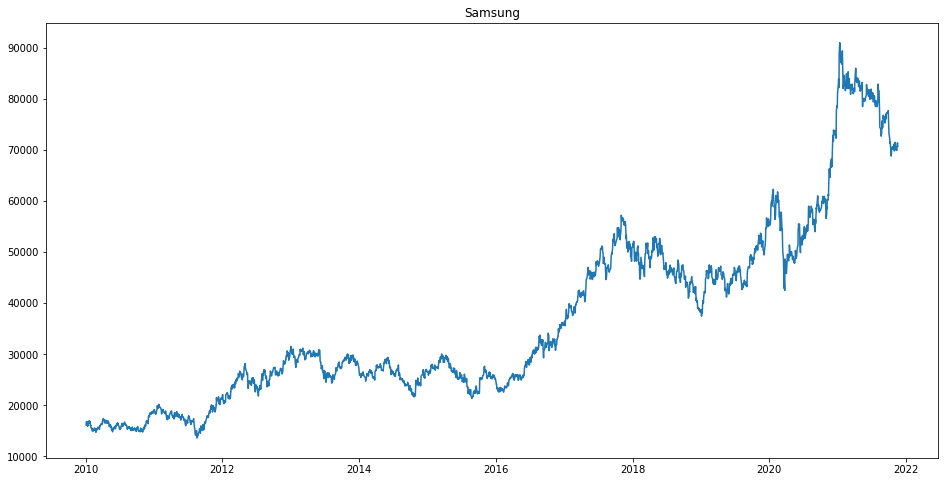

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(samsung_df["Close"])
plt.title("Samsung")

Text(0.5, 1.0, 'Woojung Bio')

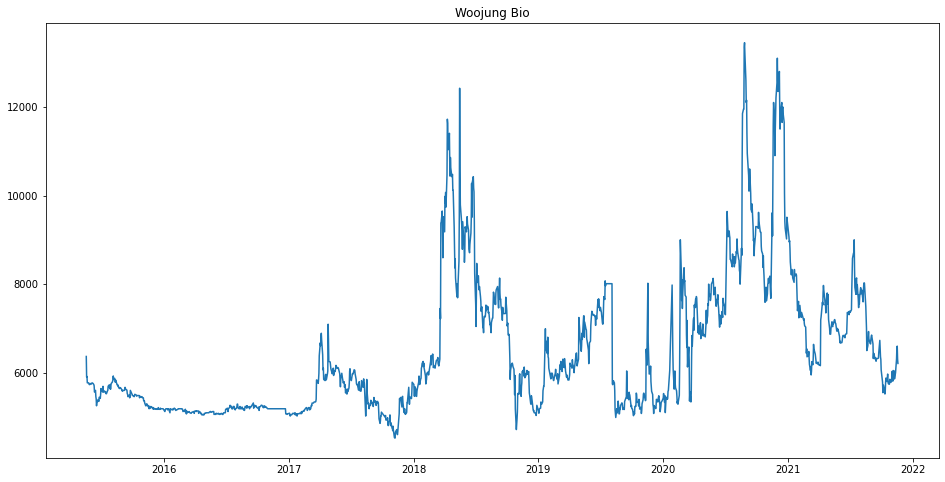

In [12]:
plt.figure(figsize=(16,8))
plt.plot(bio_df["Close"])
plt.title('Woojung Bio')

Text(0.5, 1.0, 'Access Bio')

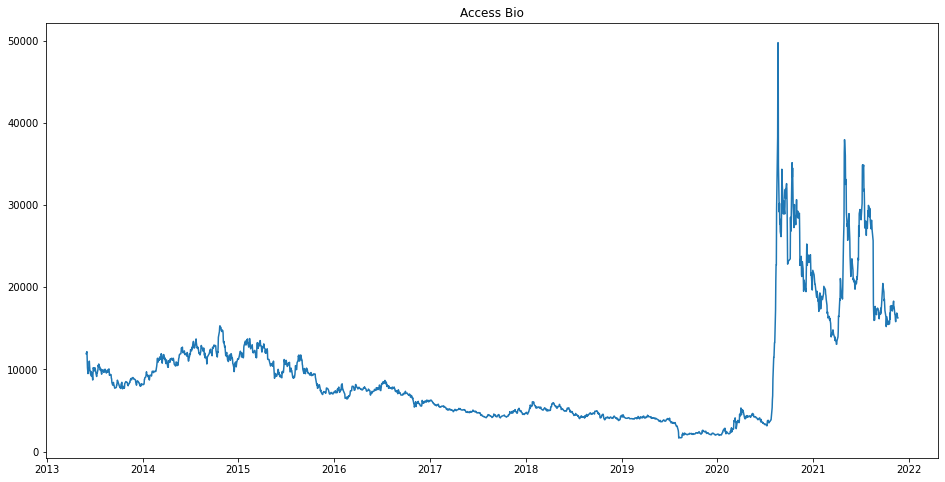

In [13]:
plt.figure(figsize=(16,8))
plt.plot(access_bio_df["Close"])
plt.title('Access Bio')

In [84]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# samsung_scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'KOSPI', 'NASDAQ']
# samsung_scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# samsung_scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'KOSPI']
# samsung_df_scaled = scaler.fit_transform(samsung_df[samsung_scale_cols])

# bio_scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'KOSDAQ', 'NASDAQ']
# bio_scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
bio_scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'KOSDAQ']
bio_df_scaled = scaler.fit_transform(bio_df[bio_scale_cols])

access_bio_scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'KOSDAQ']
access_bio_df_scaled = scaler.fit_transform(access_bio_df[access_bio_scale_cols])

# samsung_df_scaled = pd.DataFrame(samsung_df_scaled)
# samsung_df_scaled.columns = samsung_scale_cols

bio_df_scaled = pd.DataFrame(bio_df_scaled)
bio_df_scaled.columns = bio_scale_cols

access_bio_df_scaled = pd.DataFrame(access_bio_df_scaled)
access_bio_df_scaled.columns = access_bio_scale_cols

print(bio_df_scaled)
print(access_bio_df_scaled)

          Open      High       Low     Close    Volume    KOSDAQ
0     0.433808  0.468649  0.459686  0.206298  0.045462  0.426911
1     0.442989  0.440676  0.460627  0.154191  0.016658  0.430877
2     0.420783  0.417838  0.459686  0.155648  0.008300  0.445881
3     0.420783  0.409932  0.452471  0.139623  0.009213  0.445898
4     0.410605  0.393243  0.450510  0.139623  0.004540  0.440912
...        ...       ...       ...       ...       ...       ...
1550  0.437011  0.427703  0.478431  0.199910  0.005619  0.927211
1551  0.449822  0.443919  0.483137  0.229045  0.011532  0.948253
1552  0.485409  0.463514  0.502745  0.232407  0.007784  0.964455
1553  0.473310  0.451351  0.494118  0.199910  0.003471  0.954420
1554  0.449110  0.437162  0.481569  0.188705  0.002816  0.952655

[1555 rows x 6 columns]
          Open      High       Low     Close    Volume    KOSDAQ
0     0.203072  0.189189  0.271991  0.213261  0.063888  0.226008
1     0.208191  0.196343  0.265046  0.218458  0.106660  0.214823


In [85]:
TEST_SIZE = 200
# samsung_train = samsung_df_scaled[:-TEST_SIZE]
# samsung_test = samsung_df_scaled[-TEST_SIZE:]

bio_train = bio_df_scaled[:-TEST_SIZE]
bio_test = bio_df_scaled[-TEST_SIZE:]

access_bio_train = access_bio_df_scaled[:-TEST_SIZE]
access_bio_test = access_bio_df_scaled[-TEST_SIZE:]

In [86]:
import numpy as np
def make_dataset(data, label, window_size):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i : i + window_size]))
        label_list.append(np.array(label.iloc[i + window_size]))
    return np.array(feature_list), np.array(label_list)

In [87]:
# samsung_feature_cols = ['Open', 'High', 'Low', 'Volume', 'KOSPI', 'NASDAQ']
# samsung_feature_cols = ['Open', 'High', 'Low', 'Volume']
# samsung_feature_cols = ['Open', 'High', 'Low', 'Volume', 'KOSPI']
# samsung_label_cols = ['Close']

# bio_feature_cols = ['Open', 'High', 'Low', 'Volume', 'KOSDAQ', 'NASDAQ']
# bio_feature_cols = ['Open', 'High', 'Low', 'Volume']
bio_feature_cols = ['Open', 'High', 'Low', 'Volume', 'KOSDAQ']
bio_label_cols = ['Close']

access_bio_feature_cols = ['Open', 'High', 'Low', 'Volume', 'KOSDAQ']
access_bio_label_cols = ['Close']

# samsung_train_feature = samsung_train[samsung_feature_cols]
# samsung_train_label = samsung_train[samsung_label_cols]

# samsung_test_feature = samsung_test[samsung_feature_cols]
# samsung_test_label = samsung_test[samsung_label_cols]

bio_train_feature = bio_train[bio_feature_cols]
bio_train_label = bio_train[bio_label_cols]

bio_test_feature = bio_test[bio_feature_cols]
bio_test_label = bio_test[bio_label_cols]

access_bio_train_feature = access_bio_train[access_bio_feature_cols]
access_bio_train_label = access_bio_train[access_bio_label_cols]

access_bio_test_feature = access_bio_test[access_bio_feature_cols]
access_bio_test_label = access_bio_test[access_bio_label_cols]


# train dataset
# samsung_train_feature, samsung_train_label = make_dataset(samsung_train_feature, samsung_train_label, 20)
bio_train_feature, bio_train_label = make_dataset(bio_train_feature, bio_train_label, 50)
access_bio_train_feature, access_bio_train_label = make_dataset(access_bio_train_feature, access_bio_train_label, 50)

# train, validation set 생성
from sklearn.model_selection import train_test_split
# samsung_x_train, samsung_x_valid, samsung_y_train, samsung_y_valid = train_test_split(samsung_train_feature, samsung_train_label, test_size=0.2)
bio_x_train, bio_x_valid, bio_y_train, bio_y_valid = train_test_split(bio_train_feature, bio_train_label, test_size=0.2)
access_bio_x_train, access_bio_x_valid, access_bio_y_train, access_bio_y_valid = train_test_split(access_bio_train_feature, access_bio_train_label, test_size=0.2)

# test dataset (실제 예측 해볼 데이터)
# samsung_test_feature, samsung_test_label = make_dataset(samsung_test_feature, samsung_test_label, 20)
bio_test_feature, bio_test_label = make_dataset(bio_test_feature, bio_test_label, 50)
access_bio_test_feature, access_bio_test_label = make_dataset(access_bio_test_feature, access_bio_test_label, 50)

In [88]:
bio_test_label.shape, bio_test_feature.shape

((150, 1), (150, 50, 5))

In [89]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, input_shape=(access_bio_train_feature.shape[1], access_bio_train_feature.shape[2]), activation='relu', return_sequences=False))
model.add(Dense(1))

In [90]:
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(access_bio_x_train, access_bio_y_train, epochs=20,  batch_size=8, validation_data=(access_bio_x_valid, access_bio_y_valid), verbose = 0)

In [91]:
model2 = Sequential()
model2.add(LSTM(16, input_shape=(bio_train_feature.shape[1], bio_train_feature.shape[2]), activation='relu', return_sequences=False))
model2.add(Dense(1))

In [92]:
model2.compile(loss='mean_squared_error', optimizer='adam')
history2 = model2.fit(bio_x_train, bio_y_train, epochs=20,  batch_size=8, validation_data=(bio_x_valid, bio_y_valid), verbose = 0)

In [93]:
# samsung_pred = model.predict(samsung_test_feature)
bio_pred = model2.predict(bio_test_feature)
access_bio_pred = model.predict(access_bio_test_feature)

In [95]:
bio_test

,Open,High,Low,Close,Volume,KOSDAQ
1355,0.580071,0.562838,0.629804,0.410578,0.003499,0.871935
1356,0.582918,0.563514,0.642353,0.415061,0.006214,0.870073
1357,0.585053,0.563514,0.639216,0.411699,0.005216,0.900746
1358,0.589324,0.559459,0.621176,0.380323,0.006212,0.894952
1359,0.555872,0.529730,0.599216,0.351188,0.005295,0.869507
...,...,...,...,...,...,...
1550,0.437011,0.427703,0.478431,0.199910,0.005619,0.927211
1551,0.449822,0.443919,0.483137,0.229045,0.011532,0.948253
1552,0.485409,0.463514,0.502745,0.232407,0.007784,0.964455
1553,0.473310,0.451351,0.494118,0.199910,0.003471,0.954420


In [96]:
# samsung_index_ex = list(range(2643,2643+len(samsung_pred)))
# samsung_pred_df = pd.DataFrame(samsung_pred, index = samsung_index_ex)

bio_index_ex = list(range(1355,1355+len(bio_pred)))
bio_pred_df = pd.DataFrame(bio_pred, index = bio_index_ex)

access_bio_index_ex = list(range(1823,1823+len(access_bio_pred)))
access_bio_pred_df = pd.DataFrame(access_bio_pred, index = access_bio_index_ex)

In [97]:
# samsung_test_df = pd.concat([samsung_test, samsung_pred_df], axis = 1)
# samsung_test_df.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'KOSPI', 'NASDAQ', 'Predictions']
# samsung_test_df.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Predictions']
# samsung_test_df.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'KOSPI', 'Predictions']

bio_test_df = pd.concat([bio_test, bio_pred_df], axis = 1)
# bio_test_df.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'KOSDAQ', 'NASDAQ', 'Predictions']
# bio_test_df.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Predictions']
bio_test_df.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'KOSDAQ', 'Predictions']

access_bio_test_df = pd.concat([access_bio_test, access_bio_pred_df], axis = 1)
access_bio_test_df.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'KOSDAQ', 'Predictions']

In [ ]:
samsung_test_df

,Open,High,Low,Close,Volume,0,1,2,3,4,5,6
2643,0.985604,0.919421,0.966480,0.950904,0.279174,0.914368,0.917680,0.922422,0.916764,0.916656,0.924578,0.905925
2644,0.968992,0.915289,0.966480,0.962532,0.280357,0.917847,0.920389,0.923548,0.919713,0.921067,0.926592,0.909715
2645,0.985604,0.926653,0.969832,0.945736,0.341745,0.908113,0.912280,0.916053,0.909694,0.909379,0.918968,0.899089
2646,0.963455,0.928719,0.964246,0.979328,0.301846,0.909026,0.911615,0.913485,0.911198,0.912368,0.917924,0.900561
2647,0.983389,0.921488,0.966480,0.944444,0.367405,0.920725,0.920433,0.920868,0.922559,0.927108,0.925966,0.913206
...,...,...,...,...,...,...,...,...,...,...,...,...
2838,0.774086,0.723140,0.777654,0.727390,0.127224,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2839,0.777409,0.732438,0.781006,0.736434,0.111703,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2840,0.794020,0.742769,0.792179,0.746770,0.137540,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2841,0.791805,0.743802,0.796648,0.745478,0.120914,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
bio_test_df

,Open,High,Low,Close,Volume,Predictions
1353,0.570107,0.562838,0.625098,0.426266,0.005120,0.208290
1354,0.599288,0.572973,0.639216,0.409458,0.005208,0.198383
1355,0.580071,0.562838,0.629804,0.410578,0.003499,0.195888
1356,0.582918,0.563514,0.642353,0.415061,0.006214,0.190792
1357,0.585053,0.563514,0.639216,0.411699,0.005216,0.191820
...,...,...,...,...,...,...
1548,0.420641,0.414865,0.462745,0.160690,0.002850,NaN
1549,0.422064,0.416216,0.464314,0.165173,0.002555,NaN
1550,0.437011,0.427703,0.478431,0.199910,0.005619,NaN
1551,0.449822,0.443919,0.483137,0.229045,0.011532,NaN


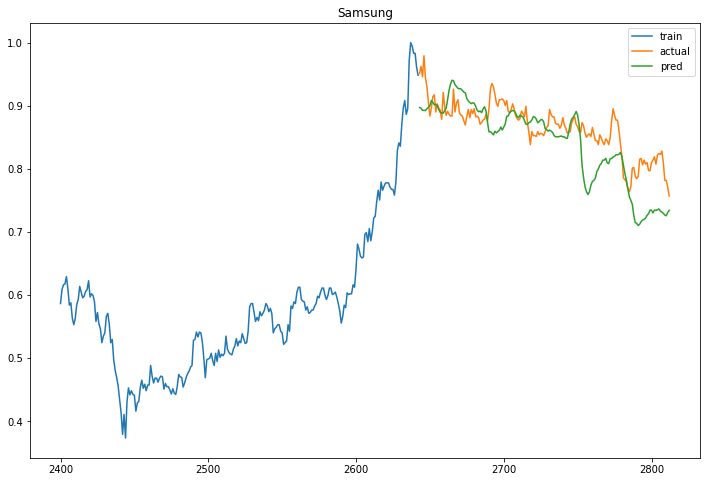

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(samsung_train[2400:]['Close'], label='train')
plt.plot(samsung_test_df[:-30]['Close'], label='actual')
plt.plot(samsung_test_df[:-30]['Predictions'], label='pred')
plt.title("Samsung")
plt.legend()
plt.show()

In [107]:
ma50_index = list(range(1405,1405+len(bio_test_df)))
ma50_bio_pred_df = bio_test_df.set_index(keys = [ma50_index], inplace = False)
ma50_bio_pred_df

,Open,High,Low,Close,Volume,KOSDAQ,Predictions
1405,0.580071,0.562838,0.629804,0.410578,0.003499,0.871935,0.301567
1406,0.582918,0.563514,0.642353,0.415061,0.006214,0.870073,0.312836
1407,0.585053,0.563514,0.639216,0.411699,0.005216,0.900746,0.339473
1408,0.589324,0.559459,0.621176,0.380323,0.006212,0.894952,0.347950
1409,0.555872,0.529730,0.599216,0.351188,0.005295,0.869507,0.389720
...,...,...,...,...,...,...,...
1600,0.437011,0.427703,0.478431,0.199910,0.005619,0.927211,NaN
1601,0.449822,0.443919,0.483137,0.229045,0.011532,0.948253,NaN
1602,0.485409,0.463514,0.502745,0.232407,0.007784,0.964455,NaN
1603,0.473310,0.451351,0.494118,0.199910,0.003471,0.954420,NaN


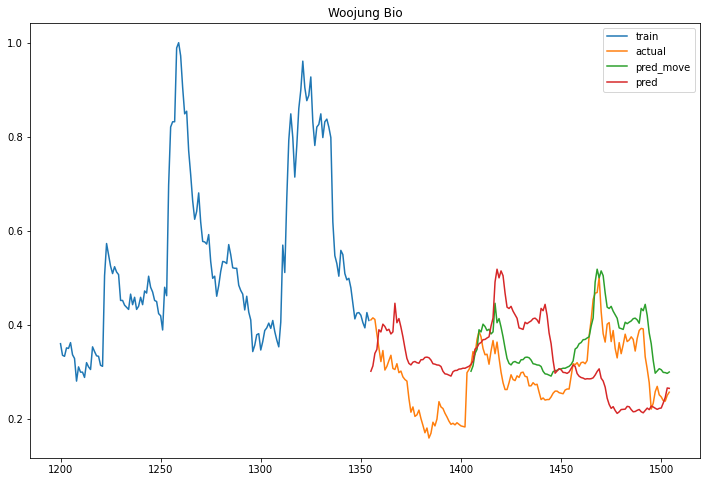

In [109]:
plt.figure(figsize=(12, 8))
plt.plot(bio_train[1200:]['Close'], label='train')
plt.plot(bio_test_df[:-50]['Close'], label='actual')
plt.plot(ma50_bio_pred_df[:-100]['Predictions'], label='pred_move')
plt.plot(bio_test_df[:-50]['Predictions'], label='pred')
plt.title("Woojung Bio")
plt.legend()
plt.show()

In [102]:
access_bio_test_df

,Open,High,Low,Close,Volume,KOSDAQ,Predictions
1823,0.303754,0.284579,0.386574,0.320308,0.020077,0.871935,0.289791
1824,0.298635,0.339428,0.395833,0.363958,0.078132,0.870073,0.300279
1825,0.331058,0.348967,0.424769,0.367075,0.083057,0.900746,0.319598
1826,0.334471,0.312401,0.428241,0.352525,0.015103,0.894952,0.340710
1827,0.318259,0.310016,0.420139,0.344211,0.013693,0.869507,0.372049
...,...,...,...,...,...,...,...
2018,0.285836,0.287758,0.387731,0.316150,0.016401,0.927211,NaN
2019,0.291809,0.271860,0.383102,0.313033,0.004980,0.948253,NaN
2020,0.289249,0.273450,0.378472,0.313033,0.008577,0.964455,NaN
2021,0.287543,0.267886,0.373843,0.303679,0.006388,0.954420,NaN


In [110]:
access_bio_ma50_index = list(range(1873,1873+len(access_bio_test_df)))
access_bio_ma50_pred_df = access_bio_test_df.set_index(keys = [access_bio_ma50_index], inplace = False)
access_bio_ma50_pred_df

,Open,High,Low,Close,Volume,KOSDAQ,Predictions
1873,0.303754,0.284579,0.386574,0.320308,0.020077,0.871935,0.289791
1874,0.298635,0.339428,0.395833,0.363958,0.078132,0.870073,0.300279
1875,0.331058,0.348967,0.424769,0.367075,0.083057,0.900746,0.319598
1876,0.334471,0.312401,0.428241,0.352525,0.015103,0.894952,0.340710
1877,0.318259,0.310016,0.420139,0.344211,0.013693,0.869507,0.372049
...,...,...,...,...,...,...,...
2068,0.285836,0.287758,0.387731,0.316150,0.016401,0.927211,NaN
2069,0.291809,0.271860,0.383102,0.313033,0.004980,0.948253,NaN
2070,0.289249,0.273450,0.378472,0.313033,0.008577,0.964455,NaN
2071,0.287543,0.267886,0.373843,0.303679,0.006388,0.954420,NaN


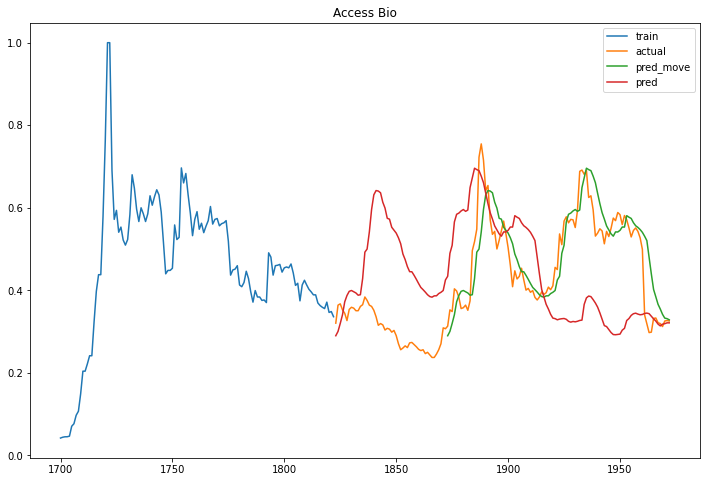

In [111]:
plt.figure(figsize=(12, 8))
plt.plot(access_bio_train[1700:]['Close'], label='train')
plt.plot(access_bio_test_df[:-50]['Close'], label='actual')
plt.plot(access_bio_ma50_pred_df[:-100]['Predictions'], label='pred_move')
plt.plot(access_bio_test_df[:-50]['Predictions'], label='pred')
plt.title("Access Bio")
plt.legend()
plt.show()